## Final Project: Study of the Bipartite Edit Network of the English Wikipedia.

##### Metadata of the dataset
This directory contains the TSV and related files of the edit-enwikinews network:

This is the bipartite edit network of the English Wikipedia. It contains users and pages from the English Wikipedia, connected by edit events. Each edge represents an edit. The dataset includes the timestamp of each edit.


More information about the network is provided here: 
http://konect.uni-koblenz.de/networks/edit-enwikinews

Files: 
    meta.edit-enwikinews -- Metadata about the network 
    out.edit-enwikinews -- The adjacency matrix of the network in space separated values format, with one edge per line
      The meaning of the columns in out.edit-enwikinews are: 
        First column: ID of from node 
        Second column: ID of to node
        Third column: edge weight
        Fourth column: timestamp of the edge


* In this project, we attempt to study the effect of time on a bipatrtite network. We want to know how periodically editors contribute to different articles using the English Wikipedia datasets. 

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from collections import defaultdict
from nxviz import MatrixPlot, CircosPlot

### Load and Explore the dataset

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/AlainKuiete/DATA620ASSIGNMENTS/master/out.edit-enwikinews",
                  sep = ' ', skiprows=1, header = None, names = ['editors', 'news', 'weight', 'timestamp'])

In [3]:
data = data.iloc[:20000,:]

In [4]:
data.editors = ['e'+str(n) for n in data.editors]
data.news = ['n'+str(n) for n in data.news]

In [5]:
data.head()

,editors,news,weight,timestamp
0,e1,n1,1,1099901502
1,e1,n1,1,1099902040
2,e2,n1,1,1105354285
3,e3,n1,1,1119228237
4,e4,n1,1,1120013820


In [6]:
data.describe()

,weight,timestamp
count,20000.0,2.000000e+04
mean,1.0,1.149681e+09
std,0.0,4.593090e+07
min,1.0,1.099902e+09
25%,1.0,1.110410e+09
50%,1.0,1.136356e+09
75%,1.0,1.181296e+09
max,1.0,1.283146e+09


#### Convert the timestamp to date format

In [7]:
data['date'] = [datetime.fromtimestamp(d) for d in data['timestamp']]

In [8]:
min(data['date'])

Timestamp('2004-11-08 03:11:42')

In [9]:
max(data['date'])

Timestamp('2010-08-30 01:32:09')

In [10]:
max(data['date']).month

8

#### Create a bipartite graph  with the degree centrality added to the metadata dictionary

In [11]:
# Instantiate a new Graph: G
G = nx.Graph()

# Add nodes from each of the partitions
G.add_nodes_from(data['editors'], bipartite = 'editors')
G.add_nodes_from(data['news'], bipartite = 'news')

# Add in each edge along with the date the edge was created
for r, d in data.iterrows():
    G .add_edge(d['editors'], d['news'], date=d['date'])

In [12]:
# Add the degree centrality score of each node to their metadata dictionary
dcs = nx.degree_centrality(G)
for n in G.nodes():
    G.nodes[n]['centrality'] = dcs[n]

#### Analyse the graph

In [13]:
print('There are: {} nodes'.format(len(G.nodes(data=True))))
print('There are: {} edges'.format(len(G.edges(data=True))))
print('The graph type is: ', type(G))

There are: 1334 nodes
There are: 3765 edges
The graph type is:  <class 'networkx.classes.graph.Graph'>


#### Plot the graph

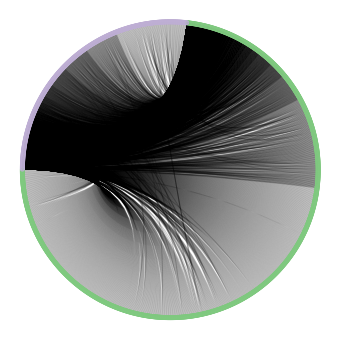

In [14]:
# Create the CircosPlot object: c
c = CircosPlot(graph = G, node_color = 'bipartite', node_grouping = 'bipartite', node_order = 'centrality')

# Draw c to the screen
c.draw()

# Display the plot
plt.show()

#### Visualise the degree centrality distribution of the editors projection

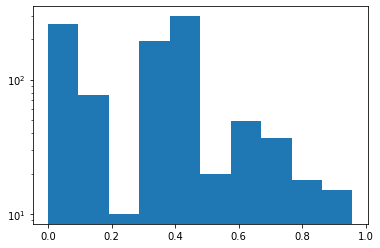

In [15]:
# Get the editor partition nodes
editors_nodes = [n for n, d in G.nodes(data=True) if d['bipartite'] == 'editors']

# Create the editor node projection as a graph
G_editors = nx.bipartite.projected_graph(G, editors_nodes)

# Calculate the degree centrality
dcs_e = nx.degree_centrality(G_editors)

# Plot the histogram of degree centrality values
plt.hist(list(dcs_e.values()))
plt.yscale('log')
plt.show()

The degree centrality is rigth skewed. Since is a bipartite graph, we have to go deeper to determine the important nodes of each partition in the graph.

We look for important collaborators

In [16]:
# Compute the maximum degree centrality: max_dc
max_dc = max(list(dcs_e.values()))

# Find the user(s) that have collaborated the most: prolific_collaborators
prolific_collaborators = [n for n, dc in dcs_e.items() if dc == max_dc]

# Print the most prolific collaborator(s)
print(prolific_collaborators)

['e38']


#### Visualize the degree centrality of the English Wikipedia news projections

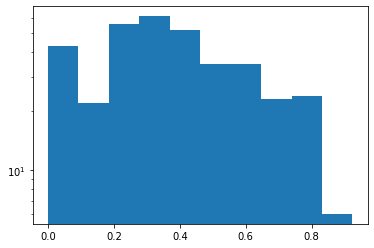

In [17]:
# Get the news partition nodes
news_nodes = [n for n, d in G.nodes(data=True) if d['bipartite'] == 'news']

# Create the news node projection as a graph
G_news = nx.bipartite.projected_graph(G, news_nodes)

# Calculate the degree centrality
dcs_n = nx.degree_centrality(G_news)

# Plot the histogram of degree centrality values
plt.hist(list(dcs_n.values()))
plt.yscale('log')
plt.show()

In [18]:
Most popular English Wikipedia.

SyntaxError: invalid syntax (<ipython-input-18-4123a01265cb>, line 1)

In [ ]:
# Compute the maximum degree centrality: max_dc
max_dc = max(list(dcs_n.values()))

# Find the user(s) that have collaborated the most: prolific_collaborators
popular_news = [n for n, dc in dcs_n.items() if dc == max_dc]

# Print the most prolific collaborator(s)
print(popular_news)

### Editors who wrote on the most popular Wikipedia articles

1. We first write a function that returns the nodes from a given partition in a bipartite graph.  The partitions are editors and news

In [19]:
# Define get_nodes_from_partition()
def get_nodes_from_partition(G, partition):
    # Initialize an empty list for nodes to be returned
    nodes = []
    # Iterate over each node in the graph G
    for n in G.nodes():
        # Check that the node belongs to the particular partition
        if G.node[n]['bipartite'] == partition:
            # If so, append it to the list of nodes
            nodes.append(n)
    return nodes


2. We use that function to make projection and calculate the sparse matrix

In [20]:
# Get the list of editors and list of wikipedia news from the graph:
editors_nodes = get_nodes_from_partition(G,'editors')
news_nodes = get_nodes_from_partition(G, 'news')

# Print the number of nodes in the 'editors' partition
print('The number of editors is: ', len(editors_nodes))

The number of editors is:  977


In [21]:
# Print the number of nodes in the 'news' partition
print('Number of English Wikipedia network: ', len(news_nodes))

Number of English Wikipedia network:  357


In [22]:
# Compute the biadjacency matrix: bi_matrix
bi_matrix = nx.bipartite.biadjacency_matrix(G, row_order=editors_nodes, column_order=news_nodes)

# Compute the editor-editor projection: user_matrix
editors_matrix = bi_matrix @ bi_matrix.T

#print(editors_matrix)

In [23]:
type(editors_matrix)

scipy.sparse.csr.csr_matrix

In [24]:
#plt.matshow(editors_matrix)
#plt.show()

Now we can find pair editors who edite the most popular articles

In [25]:
# Find out the names of editors who contribute on most number of wikipedia news
diag = editors_matrix.diagonal() 
indices = np.where(diag == diag.max())[0]  
print('Number of Wikipedia News: {0}'.format(diag.max()))
print('Editors with most contributions on Wikipedia articles:')
for i in indices:
    print('- {0}'.format(editors_nodes[i]))

# Set the diagonal to zero and convert it to a coordinate matrix format
editors_matrix.setdiag(0)
editors_coo = editors_matrix.tocoo()

# Find pairs of users who shared membership in the most number of clubs
indices2 = np.where(editors_coo.data == editors_coo.data.max())[0]
print('Editors with most number of shared memberships:')
for idx in indices2:
    print('- {0}, {1}'.format(editors_nodes[editors_coo.row[idx]], editors_nodes[editors_coo.col[idx]]))  


Number of Wikipedia News: 131
Editors with most contributions on Wikipedia articles:
- e6
Editors with most number of shared memberships:
- e36, e38
- e38, e36


### Time Series Analysis

Let's start by analyzing the graphs in which only the edges change over time.

#### Filter the graph on edges

In [26]:
# Instanciate a new graph
G_sub = nx.Graph()

# Add nodes from the original graph
G_sub.add_nodes_from(G.nodes(data=True))

# Add edges using a list comprehension
G_sub.add_edges_from([u, v, d] for u, v, d in G.edges(data=True) if d['date'] < datetime(2007, 9, 26))

#### Visualize the filtered graph 

In [27]:
# Compute the degree centrality score for each node
dcs = nx.bipartite.degree_centrality(G, nodes= news_nodes)
for n, d, in G_sub.nodes(data=True):
    G_sub.nodes[n]['dc'] = dcs[n]


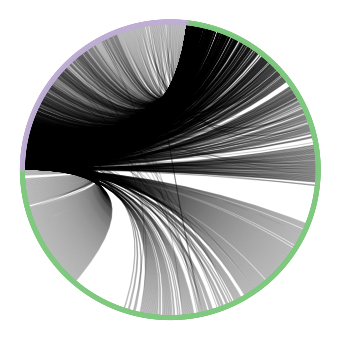

In [28]:
# Create the CircosPlot object
c = CircosPlot(graph=G_sub, node_color='bipartite', node_grouping='bipartite', node_order='dc')
# Draw c
c.draw()

# Display
plt.show()

In [29]:
months = range(1, 8)
data['month'] = [date.month for date in data['date']]

# Initialize an empty list: Gs
Gs = [] 
for month in months:
    # Instantiate a new undirected graph: F
    F = nx.Graph()
    
    # Add in all nodes that have ever shown up to the graph
    F.add_nodes_from(data['editors'])
    F.add_nodes_from(data['news'])
    
    # Filter the DataFrame so that there's only the given month
    df_filtered = data[data['month'] == month]
    
    # Add edges from filtered DataFrame
    F.add_edges_from(zip(df_filtered['editors'], df_filtered['news']))
    
    # Append F to the list of graphs
    Gs.append(F)
    
print(len(Gs))

7


Graph differences over time

In [30]:
 # Instantiate a list of graphs that show edges added: added
added = []
# Instantiate a list of graphs that show edges removed: removed
removed = []
# Here's the fractional change over time
fractional_changes = []
window = 1  
i = 0      

for i in range(len(Gs) - window):
    g1 = Gs[i]
    g2 = Gs[i + window]
        
    # Compute graph difference here
    added.append(nx.difference(g2, g1))   
    removed.append(nx.difference(g1, g2))
    
    # Compute change in graph size over time
    fractional_changes.append((len(g2.edges()) - len(g1.edges())) / len(g1.edges()))
    
# Print the fractional change
print('Fraction of nodes that change between January and Julliet', fractional_changes)

Fraction of nodes that change between January and Julliet [-0.1799163179916318, 0.36989795918367346, -0.15456238361266295, -0.1211453744493392, -0.08521303258145363, 0.26575342465753427]


Plot number of edge changes over time¶

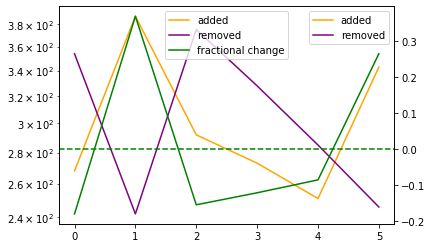

In [31]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

# Plot the number of edges added over time
edges_added = [len(g.edges()) for g in added]
plot1 = ax1.plot(edges_added, label='added', color='orange')

# Plot the number of edges removed over time
edges_removed = [len(g.edges()) for g in removed]
plot2 = ax1.plot(edges_removed, label='removed', color='purple')

# Set yscale to logarithmic scale
ax1.set_yscale('log')  
ax1.legend()

# 2nd axes shares x-axis with 1st axes object
ax2 = ax1.twinx()

# Plot the fractional changes over time
plot3 = ax2.plot(fractional_changes, label='fractional change', color='green')

# Here, we create a single legend for both plots
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc=0)
plt.axhline(0, color='green', linestyle='--')
plt.show()

Number of English Wikipedia articles been edited over time


2005-02-01 03:11:42
2005-06-01 03:11:42
2005-07-01 03:11:42
2006-02-01 03:11:42
2006-06-01 03:11:42
2006-07-01 03:11:42
2007-02-01 03:11:42
2007-06-01 03:11:42
2007-07-01 03:11:42
2008-02-01 03:11:42
2008-04-01 03:11:42
2008-05-01 03:11:42
2009-01-01 03:11:42
2009-04-01 03:11:42
2009-05-01 03:11:42
2010-01-01 03:11:42
2010-04-01 03:11:42
2010-05-01 03:11:42


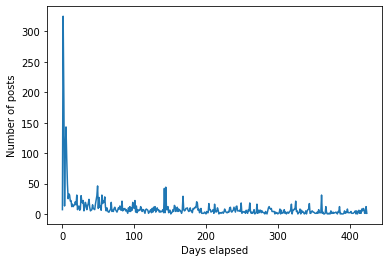

In [32]:
# Define current day and timedelta of 2 days
dayone = min(data['date'])
lastday = max(data['date'])
curr_day = dayone
td = timedelta(5)

# Initialize an empty list of posts by day
n_posts = []
while curr_day < lastday:
    if curr_day.day == 1:
        print(curr_day) 
    # Filter edges such that they are within the sliding time window: edges
    edges = [(u, v, d) for u, v, d in G.edges(data=True) if d['date'] >= curr_day and d['date'] < curr_day + td]
    
    # Append number of edges to the n_posts list
    n_posts.append(len(edges))
    
    # Increment the curr_day by the time delta
    curr_day += td
    
# Create the plot
plt.plot(n_posts)  
plt.xlabel('Days elapsed')
plt.ylabel('Number of posts')
plt.show()  


### Extract the daily mean degree centrality on the editors partition

We are looking at the correlation between  the mean degree centrality and the number of Wikipedia articles that are edited daily.

In [41]:
# Initialize a new list: mean_dcs
mean_dcs = []
curr_day = dayone
td = timedelta(days=5)

while curr_day < lastday:
    if curr_day.day == 1:
        print(curr_day)  
    # Instantiate a new graph containing a subset of edges: G_sub
    G_sub = nx.Graph()
    # Add nodes from G
    G_sub.add_nodes_from(G.nodes(data=True))
    # Add in edges that fulfill the criteria
    G_sub.add_edges_from([(u, v, d) for u, v, d in G.edges(data=True) if d['date'] >= curr_day and d['date'] < curr_day + td])
    
    # Get the editors projection
    G_editors_sub = nx.bipartite.projected_graph(G_sub, editors_nodes)
    # Compute the degree centrality of the editors projection
    dc = nx.degree_centrality(G_editors_sub)
    # Append mean degree centrality to the list mean_dcs
    mean_dcs.append(np.mean(list(dc.values())))
    # Increment the time
    curr_day += td
    

2005-02-01 03:11:42
2005-06-01 03:11:42
2005-07-01 03:11:42
2006-02-01 03:11:42
2006-06-01 03:11:42
2006-07-01 03:11:42
2007-02-01 03:11:42
2007-06-01 03:11:42
2007-07-01 03:11:42
2008-02-01 03:11:42
2008-04-01 03:11:42
2008-05-01 03:11:42
2009-01-01 03:11:42
2009-04-01 03:11:42
2009-05-01 03:11:42
2010-01-01 03:11:42
2010-04-01 03:11:42
2010-05-01 03:11:42


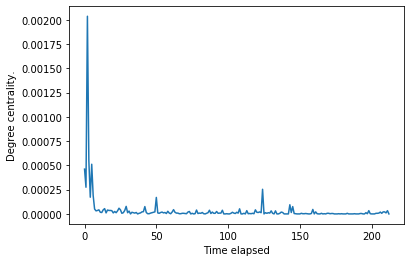

In [34]:
plt.plot(mean_dcs)
plt.xlabel('Time elapsed')
plt.ylabel('Degree centrality.')
plt.show()

#### Find the most popular news day-by-day: 
We're going to create a time-series graph list.

We're going to see how many English Wikipedia news took the title of "the most popular news" on any given time window.

We'll find out how many Wikipedia news had the most popular news score on a per-day basis!


In [35]:
most_popular_news = []
highest_dcs = []
curr_day = dayone 
td = timedelta(days=10)  

while curr_day < lastday:  
    if curr_day.day == 1:  
        print(curr_day)  
    G_sub = nx.Graph()
    G_sub.add_nodes_from(G.nodes(data=True))   
    G_sub.add_edges_from([(u, v, d) for u, v, d in G.edges(data=True) if d['date'] >= curr_day and d['date'] < curr_day + td])
    
    # Get the degree centrality 
    dc = nx.bipartite.degree_centrality(G_sub, news_nodes)
    # Filter the dictionary such that there's only news degree centralities
    news_dcs = {n:dc for n, dc in dc.items() if n in news_nodes}
    # Identify the most popular news 
    popular_news = [n for n, dc in news_dcs.items() if dc == max(news_dcs.values()) and dc != 0] 
    most_popular_news.append(popular_news) 
    # Store the highest dc values in highest_dcs
    highest_dcs.append(max(news_dcs.values()))
    
    curr_day += td  
    


2006-02-01 03:11:42
2006-06-01 03:11:42
2006-07-01 03:11:42
2008-02-01 03:11:42
2008-04-01 03:11:42
2008-05-01 03:11:42
2010-01-01 03:11:42
2010-04-01 03:11:42
2010-05-01 03:11:42


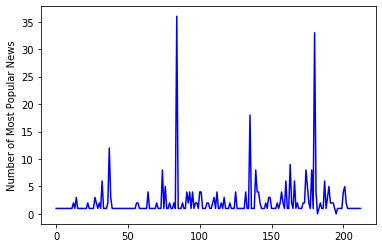

In [42]:
plt.figure(1) 
plt.plot([len(n) for n in most_popular_news], color='blue', label='Forums')
plt.ylabel('Number of Most Popular News')
plt.show()

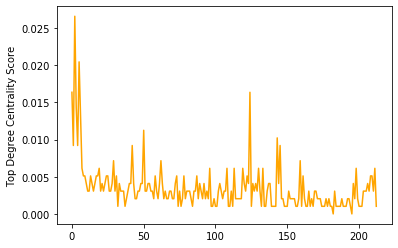

In [43]:
plt.figure(2)
plt.plot(highest_dcs, color='orange', label='DC Score')
plt.ylabel('Top Degree Centrality Score')
plt.show()

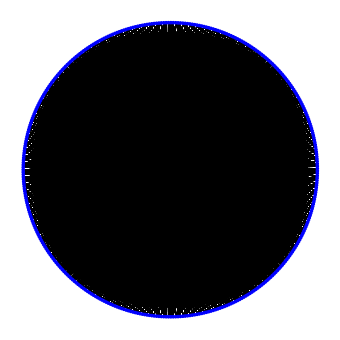

In [38]:
# Find the author(s) that are part of the largest maximal clique: largest_clique
largest_clique = sorted(nx.find_cliques(G_editors), key=lambda x:len(x))[-1]

# Create the subgraph of the largest_clique: G_lc
G_lc = G_editors.subgraph(largest_clique)

# Create the CircosPlot object: c
c = CircosPlot(G_lc)

# Draw the CircosPlot to the screen
c.draw()
plt.show()

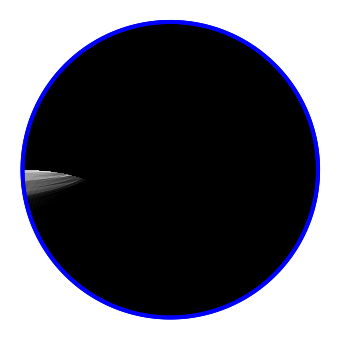

In [39]:
# Identify the largest maximal clique: largest_max_clique
largest_max_clique = set(sorted(nx.find_cliques(G_editors), key=lambda x: len(x))[-1])

# Create a subgraph from the largest_max_clique: G_lmc
G_lmc = G_editors.subgraph(largest_max_clique).copy()  

# Go out 1 degree of separation
for node in list(G_lmc.nodes()):
    G_lmc.add_nodes_from(G_editors.neighbors(node))
    G_lmc.add_edges_from(zip([node]*len(list(G_editors.neighbors(node))), G_editors.neighbors(node)))

# Record each node's degree centrality score
for n in G_lmc.nodes():
    G_lmc.node[n]['degree centrality'] = nx.degree_centrality(G_lmc)[n]

# Create the ArcPlot object: a
a = CircosPlot(G_lmc, node_order='degree centrality')

# Draw the ArcPlot to the screen
a.draw()
plt.show()

##### Recommending co-editors who have yet to edit together

In [44]:
# Import necessary modules
from itertools import combinations
from collections import defaultdict

# Initialize the defaultdict: recommended
recommended = defaultdict(int)

# Iterate over all the nodes in G
for n, d in G_editors.nodes(data=True):

    # Iterate over all possible triangle relationship combinations
    for n1, n2 in combinations(G_editors.neighbors(n), 2):

        # Check whether n1 and n2 do not have an edge
        if not G_editors.has_edge(n1, n2):

            # Increment recommended
            recommended[(n1, n2)] += 1

# Identify the top 10 pairs of users
all_counts = sorted(recommended.values())
top10_pairs = [pair for pair, count  in recommended.items() if count > all_counts[-10]]
print(top10_pairs)


[('e108', 'e635'), ('e13', 'e154'), ('e13', 'e241'), ('e13', 'e181'), ('e177', 'e210'), ('e76', 'e137'), ('e76', 'e131'), ('e5', 'e126'), ('e13', 'e126')]


#### References
1. Project 2: Movie and User Similarity in the MovieLens Dataset
By Dmitriy Vecheruk
2.  Intermediate Network Analysis in Python
By Eric Ma, DataCamp